### Protein Family Classification

In [2]:
import pandas as pd
import tensorflow as tf

import tarfile
import re
import urllib.request
import os
import random

import numpy as np

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from lazy import lazy

In [3]:
family_classification_metadata = pd.read_table('../hw5/data/family_classification_metadata.tab')
family_classification_sequences = pd.read_table('../hw5/data/family_classification_sequences.tab')

In [4]:
family_classification_metadata.head()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
0,Q6GZX4,001R_FRG3G,Putative transcription factor 001R,Pox_VLTF3,Poxvirus Late Transcription Factor VLTF3 like
1,Q6GZX3,002L_FRG3G,Uncharacterized protein 002L,DUF230,Poxvirus proteins of unknown function
2,Q6GZX0,005R_FRG3G,Uncharacterized protein 005R,US22,US22 like
3,Q91G88,006L_IIV6,Putative KilA-N domain-containing protein 006L,DUF3627,Protein of unknown function (DUF3627)
4,Q197F3,007R_IIV3,Uncharacterized protein 007R,DUF2738,Protein of unknown function (DUF2738)


In [5]:
family_classification_sequences.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [6]:
family_classification_metadata.describe()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
count,324018,324018,324018,324018,324018
unique,287308,295671,56951,7027,6967
top,Q1X881,POLG_DEN2Q,UvrABC system protein B,MMR_HSR1,50S ribosome-binding GTPase
freq,16,12,1500,3084,3084


In [7]:
family_cnt_exmp = dict()
for i in range(len(family_classification_metadata)):
    cur_fam_id = family_classification_metadata["FamilyID"][i]
    if (cur_fam_id not in family_cnt_exmp):
        family_cnt_exmp[cur_fam_id] = 0
    family_cnt_exmp[cur_fam_id] += 1

familys_sort = []
for k, v in family_cnt_exmp.items():
    familys_sort.append((v, k))
familys_sort.sort(reverse=True)

most_frequent_families = []
for i in range(1000):
    most_frequent_families.append(familys_sort[i][1])

print(most_frequent_families)

['MMR_HSR1', 'Helicase_C', 'ATP-synt_ab', '7tm_1', 'AA_kinase', 'AAA', 'tRNA-synt_1', 'tRNA-synt_2', 'MFS_1', 'HSP70', 'Oxidored_q1', 'His_biosynth', 'Cpn60_TCP1', 'EPSP_synthase', 'Aldedh', 'Shikimate_DH', 'GHMP_kinases_N', 'Ribosomal_S2', 'Ribosomal_S4', 'Ribosomal_L16', 'KOW', 'UPF0004', 'Ribosom_S12_S23', 'GHMP_kinases_C', 'Ribosomal_S14', 'Ribosomal_S11', 'UVR', 'Ribosomal_L33', 'BRCT', 'RF-1', 'Ank_2', 'Ribosomal_L20', 'RNA_pol_Rpb2_1', 'Ribosomal_S18', 'ATP-synt_B', 'Peptidase_M20', 'Ribosomal_L18e', 'GIDA', 'Oxidored_q2', 'Ldh_1_N', 'HD', 'Ribosomal_S10', 'PALP', 'Ribosomal_L18p', 'Ribosomal_L3', 'tRNA-synt_1g', 'UbiA', 'Ribosomal_L4', 'Ribosomal_S16', 'Ribosomal_S13', 'Methyltransf_5', 'Ribosomal_L32p', 'EF_TS', 'THF_DHG_CYH', 'OSCP', 'tRNA-synt_1e', 'SecA_SW', 'Ribosomal_L31', 'RNase_HII', 'Ribosomal_L27', 'IPPT', 'LepA_C', 'Ribosomal_L17', 'Ribosomal_L23', 'Ribosomal_L10', 'Ribosomal_L19', 'Ribosomal_S20p', 'Ribosomal_L35p', 'PGM_PMM_IV', 'AMP-binding', 'Ribosomal_L21p', 'tR

In [8]:
families_protein_id_list = dict()
for i in range(1000):
    families_protein_id_list[most_frequent_families[i]] = []

for i in range(len(family_classification_metadata)):
    cur_fam_id = family_classification_metadata["FamilyID"][i]
    if (cur_fam_id in families_protein_id_list):
        families_protein_id_list[cur_fam_id].append(i)

train_id = []
test_id = []
        
for i in range(1000):
    random.shuffle(families_protein_id_list[most_frequent_families[i]])
    cnt_train = len(families_protein_id_list[most_frequent_families[i]]) * 8//10
    for j in range(cnt_train):
        train_id.append(families_protein_id_list[most_frequent_families[i]][j])
    for j in range(cnt_train, len(families_protein_id_list[most_frequent_families[i]])):
        test_id.append(families_protein_id_list[most_frequent_families[i]][j])
random.shuffle(train_id)
random.shuffle(test_id)

print("train", train_id)
print("test", test_id)

train [195294, 192410, 277534, 178272, 222747, 135816, 272440, 1871, 155674, 186011, 294016, 42325, 189832, 254175, 160342, 233348, 71374, 124078, 233545, 107749, 224048, 188582, 18937, 101960, 219668, 288582, 47470, 267194, 179161, 108941, 170793, 54691, 109381, 252506, 191836, 262734, 231175, 41217, 158443, 241897, 152, 233555, 218525, 194350, 320813, 223536, 288776, 51166, 322671, 218679, 22822, 225383, 93387, 207235, 153506, 207796, 193678, 297442, 45160, 167120, 81655, 118542, 151943, 246792, 197522, 230631, 139975, 88668, 225042, 194320, 116498, 59697, 260423, 293272, 87641, 306884, 34156, 10602, 172778, 25365, 280554, 97184, 19159, 314065, 235176, 270577, 217220, 240497, 23196, 147567, 319056, 140194, 94647, 80104, 216754, 107773, 210416, 296282, 3123, 154520, 237530, 265658, 305843, 91130, 148654, 37005, 180045, 222441, 245445, 43671, 173659, 53721, 294843, 296416, 177556, 195894, 200496, 127455, 199330, 4325, 315361, 56460, 145228, 32344, 154871, 322525, 51210, 229423, 234731,

In [9]:
embed_matrix = pd.read_csv("protVec_100d_3grams.csv", sep='\\t', header=None, engine='python', index_col=0)
embed_matrix.head()
print(embed_matrix)

            1         2         3         4         5         6         7    \
0                                                                             
AAA   -0.174060 -0.095756  0.059515  0.039673 -0.375934 -0.115415  0.090725   
ALA   -0.114085 -0.093288  0.155800 -0.037351 -0.121446  0.084037  0.023819   
LLL   -0.075594 -0.100834 -0.046616 -0.208980 -0.008596 -0.038612 -0.049360   
LAA   -0.137546 -0.135425  0.121566 -0.038295 -0.212129  0.040009  0.078545   
AAL   -0.156112 -0.133524  0.114426 -0.020264 -0.058513  0.057005  0.076881   
ALL   -0.056191 -0.144594  0.043214 -0.146754 -0.058094  0.024076  0.074966   
LLA   -0.177890 -0.001898  0.032638 -0.053407 -0.036736 -0.021239 -0.013052   
LAL   -0.188611 -0.002185  0.108836 -0.126098 -0.001931 -0.017215 -0.056647   
SSS    0.012405 -0.368833 -0.368951 -0.212781 -0.227907 -0.243726  0.056344   
EAL   -0.143734 -0.074760 -0.033182  0.061196 -0.107497  0.112890  0.055947   
AAG   -0.122047 -0.131051  0.082267  0.007056 -0.133

In [10]:
seq_to_id = dict()
id_list = embed_matrix.index.tolist();
for i in range(len(embed_matrix)):
    seq_to_id[id_list[i]] = i

print(seq_to_id)

{'AAA': 0, 'ALA': 1, 'LLL': 2, 'LAA': 3, 'AAL': 4, 'ALL': 5, 'LLA': 6, 'LAL': 7, 'SSS': 8, 'EAL': 9, 'AAG': 10, 'LGL': 11, 'LLS': 12, 'ELL': 13, 'LLE': 14, 'LLG': 15, 'SLL': 16, 'VAA': 17, 'LAE': 18, 'GGG': 19, 'AGL': 20, 'EEL': 21, 'AVA': 22, 'EEE': 23, 'LSL': 24, 'VLA': 25, 'ALG': 26, 'AAV': 27, 'LAG': 28, 'VLL': 29, 'GLL': 30, 'EAA': 31, 'AGA': 32, 'LLD': 33, 'ELA': 34, 'LEE': 35, 'ALE': 36, 'AVL': 37, 'LLK': 38, 'AEA': 39, 'AEL': 40, 'GLA': 41, 'LEA': 42, 'EKL': 43, 'RLL': 44, 'ALV': 45, 'ALR': 46, 'LGA': 47, 'LEK': 48, 'LKE': 49, 'AAE': 50, 'LVA': 51, 'DLL': 52, 'LLV': 53, 'LLR': 54, 'LVL': 55, 'LAR': 56, 'SSL': 57, 'LAS': 58, 'KLL': 59, 'GAA': 60, 'SAL': 61, 'TLL': 62, 'RAL': 63, 'LSA': 64, 'LAK': 65, 'DAL': 66, 'VAL': 67, 'GAG': 68, 'ALS': 69, 'AAR': 70, 'LSS': 71, 'LSG': 72, 'KAL': 73, 'SLA': 74, 'LAV': 75, 'LAD': 76, 'LGG': 77, 'ASL': 78, 'AIA': 79, 'RLA': 80, 'AGV': 81, 'SLS': 82, 'KEL': 83, 'LLT': 84, 'GAL': 85, 'VVA': 86, 'ERL': 87, 'LDL': 88, 'LEL': 89, 'ELE': 90, 'AAS': 9

In [11]:
tsne = TSNE(n_components=2, random_state=42)
XX = tsne.fit_transform(embed_matrix)


tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
tsne_df.head()

,x0,x1
0,3.448284,-3.949775
1,2.758263,-4.583681
2,1.407525,-5.544826
3,2.729012,-4.329892
4,2.790550,-4.428670


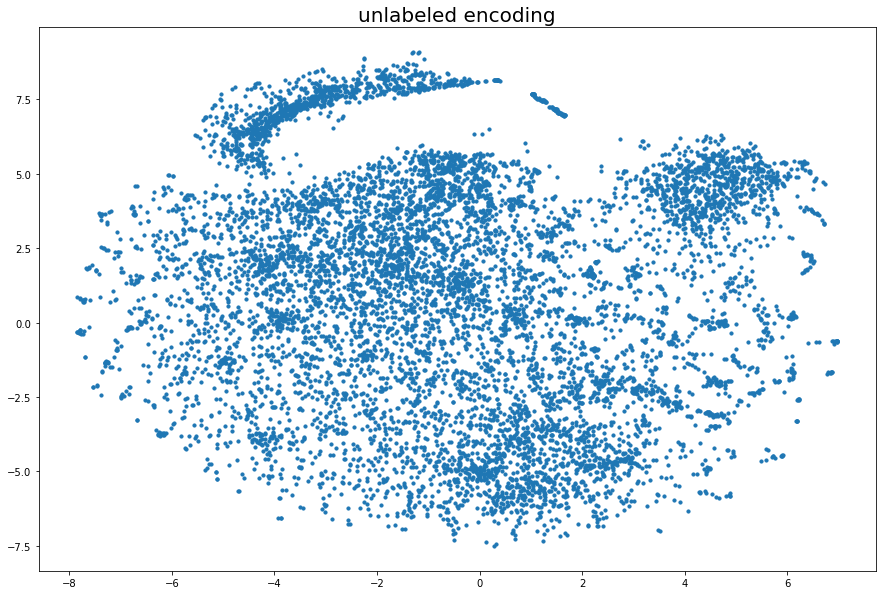

In [12]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

plot_tsne_df(tsne_df)

In [13]:
def acid_dict(seq, family):
    x0 = 0
    x1 = 0
    for i in range(0,len(seq),3):
        subseq = seq[i:i + 3]
        if (len(subseq) == 3):
            x0 += tsne_df["x0"][seq_to_id[subseq]]
            x1 += tsne_df["x1"][seq_to_id[subseq]]
    
    dres = dict()
    dres["x0"] = x0
    dres["x1"] = x1
    dres["fam"] = family
    return dres

p0 = most_frequent_families[0]
p1 = most_frequent_families[1] 
all_prot_dict = []
for i in range(len(family_classification_metadata)):
    if (family_classification_metadata["FamilyID"][i] == p0):
        all_prot_dict.append(acid_dict(family_classification_sequences["Sequences"][i], 0))
    
    if (family_classification_metadata["FamilyID"][i] == p1):
        all_prot_dict.append(acid_dict(family_classification_sequences["Sequences"][i], 1))


all_prot_df = pd.DataFrame(all_prot_dict)
all_prot_df.head()

,fam,x0,x1
0,1,-231.135196,128.645268
1,0,-72.976207,149.635431
2,1,-102.572238,242.292548
3,1,-72.493335,85.800772
4,1,-19.806498,151.765979


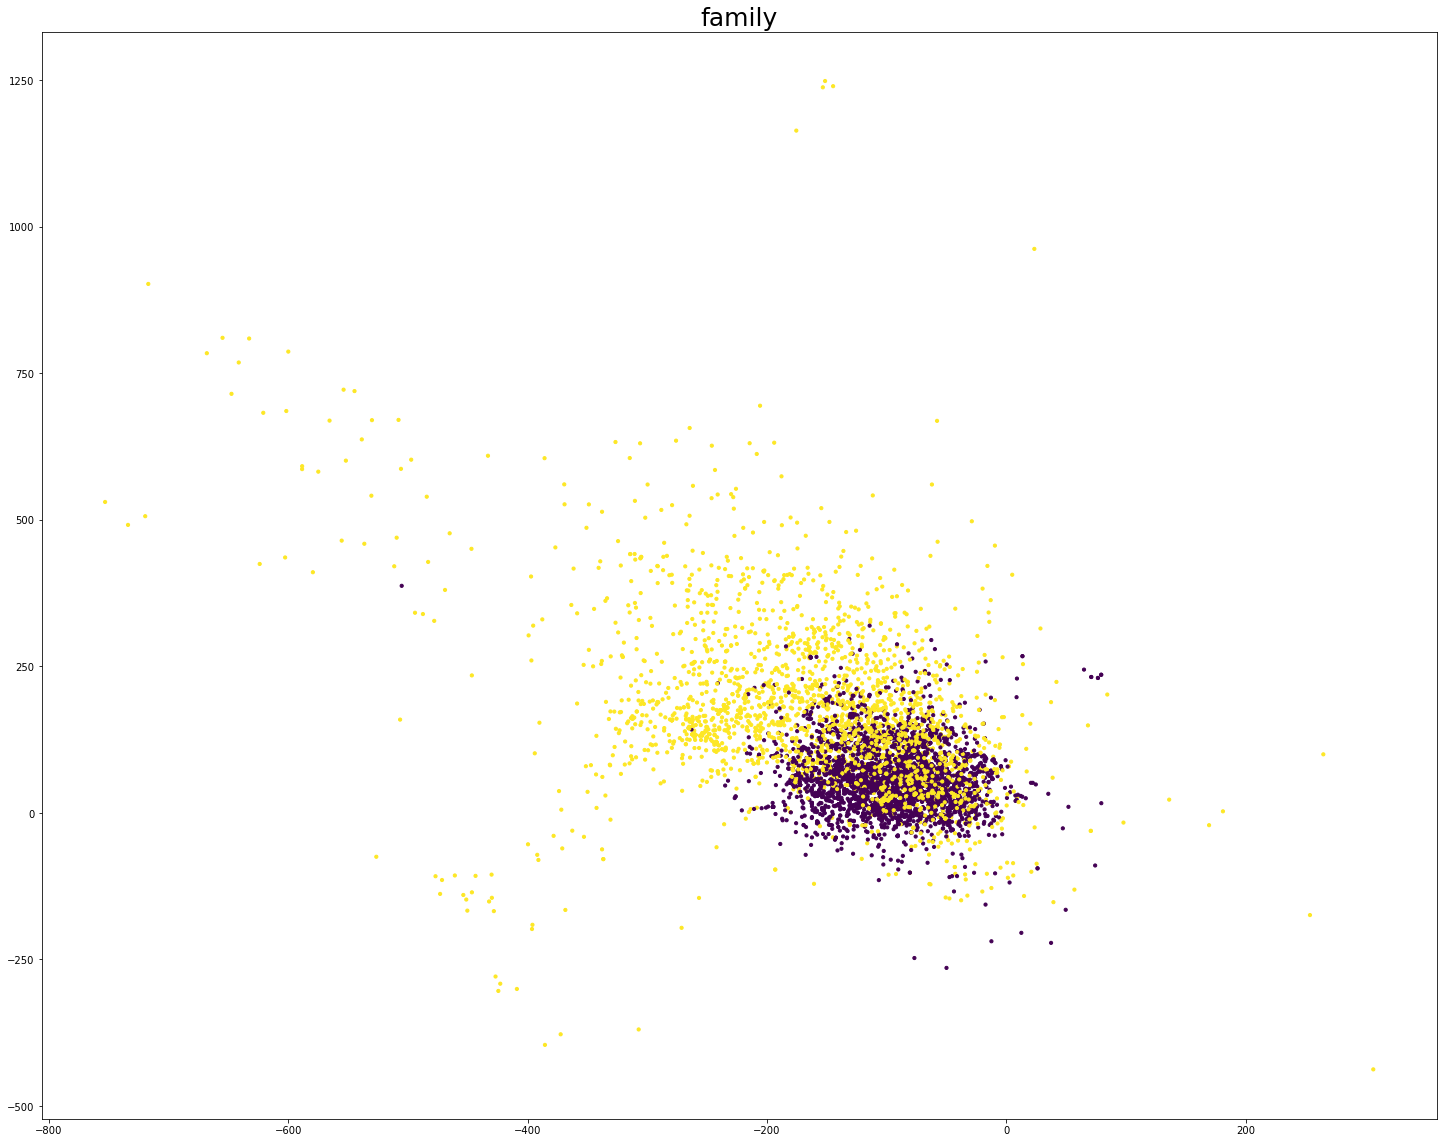

In [14]:
def plot_embedding_properties(all_prot_df):
    plt.figure(figsize=(25, 20))
    plt.title("family", fontsize=25)
    plt.scatter(all_prot_df.x0, all_prot_df.x1, c=all_prot_df.fam, s=10)
    plt.show()

plot_embedding_properties(all_prot_df)

In [15]:
class SequenceClassificationModel:
    def __init__(self, params):
        self.params = params
        self._create_placeholders()
        self.prediction
        self.cost
        self.error
        self.optimize
        self._create_summaries()
    
    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.data = tf.placeholder(tf.float32, [None, self.params.seq_length, self.params.embed_length])
            self.target = tf.placeholder(tf.float32, [None, 1000])
  
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar('loss', self.cost)
            tf.summary.scalar('erroe', self.error)
            self.summary = tf.summary.merge_all()
            saver = tf.train.Saver()
            
    @lazy
    def length(self):
        with tf.name_scope("seq_length"):
            used = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
            length = tf.reduce_sum(used, reduction_indices=1)
            length = tf.cast(length, tf.int32)
        return length
    
    @lazy
    def prediction(self):
        with tf.name_scope("recurrent_layer"):
            output, _ = tf.nn.dynamic_rnn(
                self.params.rnn_cell(self.params.rnn_hidden),
                self.data,
                dtype=tf.float32,
                sequence_length=self.length
            )
        last = self._last_relevant(output, self.length)

        with tf.name_scope("softmax_layer"):
            num_classes = int(self.target.get_shape()[1])
            weight = tf.Variable(tf.truncated_normal(
                [self.params.rnn_hidden, num_classes], stddev=0.01))
            bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
            prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)
        return prediction
    
    @lazy
    def cost(self):
        cross_entropy = -tf.reduce_sum(self.target * tf.log(self.prediction))
        return cross_entropy
    
    @lazy
    def error(self):
        self.mistakes = tf.not_equal(
            tf.argmax(self.target, 1), tf.argmax(self.prediction, 1))
        return tf.reduce_mean(tf.cast(self.mistakes, tf.float32))
    
    @lazy
    def optimize(self):
        with tf.name_scope("optimization"):
            gradient = self.params.optimizer.compute_gradients(self.cost)
            if self.params.gradient_clipping:
                limit = self.params.gradient_clipping
                gradient = [
                    (tf.clip_by_value(g, -limit, limit), v)
                    if g is not None else (None, v)
                    for g, v in gradient]
            optimize = self.params.optimizer.apply_gradients(gradient)
        return optimize
    
    @staticmethod
    def _last_relevant(output, length):
        with tf.name_scope("last_relevant"):
            batch_size = tf.shape(output)[0]
            max_length = int(output.get_shape()[1])
            output_size = int(output.get_shape()[2])

            index = tf.range(0, batch_size) * max_length + (length - 1)
            flat = tf.reshape(output, [-1, output_size])
            relevant = tf.gather(flat, index)
        return relevant

In [16]:
length = 0
for i in range(len(family_classification_sequences)):
    length = max(length, len(family_classification_sequences["Sequences"][i])//3 + 1)
print(length)

embed_len = 100

7385


In [22]:
def find_fam(sid):
    famName =  family_classification_metadata["FamilyID"][sid]
    for i in range(len(most_frequent_families)):
        if (most_frequent_families[i] == famName):
            return i
    return -1

def get_embed(sid):
    seq = family_classification_sequences["Sequences"][sid]
    data = np.zeros((length, embed_len))
    
    for i in range(0,len(seq),3):
        subseq = seq[i:i + 3]
        if subseq in seq_to_id:
            if (len(subseq) == 3):
                for j in range(1, 101):
                    data[i][j - 1] = embed_matrix[j][subseq]
    return data
    

In [23]:
def preprocess_batched(seq_id, batch_size):
    i = 0
    while (i < len(seq_id)):
        data = np.zeros((batch_size, length, embed_len))
        target = np.zeros((batch_size, 1000))
        
        for j in range(batch_size):
            sid = seq_id[i]
            i += 1
            label = find_fam(sid)
            data[j] = get_embed(sid)
            target[j][label] = 1
        yield data, target

In [24]:
from attrdict import AttrDict

params = AttrDict(
    rnn_cell=tf.contrib.rnn.GRUCell,
    rnn_hidden=100,
    optimizer=tf.train.RMSPropOptimizer(0.002),
    batch_size=20,
    gradient_clipping=100,
    seq_length=length,
    embed_length=embed_len
)

In [25]:
batches = preprocess_batched(train_id, params.batch_size)

In [ ]:
tf.reset_default_graph()
model = SequenceClassificationModel(params)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    summary_writer = tf.summary.FileWriter('graphs', sess.graph)
    for index, batch in enumerate(batches):
        feed = {model.data: batch[0], model.target: batch[1]}
        error, _, summary_str = sess.run([model.error, model.optimize, model.summary], feed)
        print('{}: {:3.1f}%'.format(index + 1, 100 * error))
        if index % 1 == 0:
            summary_writer.add_summary(summary_str, index)

/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1: 100.0%
2: 100.0%
3: 100.0%
4: 100.0%
5: 100.0%
6: 100.0%
7: 100.0%
8: 100.0%
9: 100.0%
10: 100.0%
11: 100.0%
12: 100.0%
13: 100.0%
14: 100.0%
15: 95.0%
16: 100.0%
17: 95.0%
18: 100.0%
19: 100.0%
20: 100.0%
21: 100.0%
22: 100.0%
23: 100.0%
24: 100.0%
25: 100.0%
26: 95.0%
27: 100.0%
28: 100.0%
29: 100.0%
30: 100.0%
31: 100.0%
32: 95.0%
33: 95.0%
34: 100.0%
35: 100.0%
36: 100.0%
37: 95.0%
38: 95.0%
39: 100.0%
40: 100.0%
41: 100.0%
42: 100.0%
43: 95.0%
44: 100.0%
45: 95.0%
46: 100.0%
47: 100.0%
48: 100.0%
49: 100.0%
50: 100.0%
51: 100.0%
52: 90.0%


#### Task:
    
Use your ProtVec embedding from homework 5 to perform protein family classification using RNN.

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

* use 1000 most frequent families for classification
* validate your results on the train-test split
* reduce the dimensionality of the protein-space using Stochastic Neighbor Embedding and visualize two most frequent classes
* compare your RNN results with SVM
* visualization and metrics are up to you